# (15) SLC: particip. coeff. shared colorbar

**Motivation**: <br>

In [1]:
# HIDE CODE


import os, sys
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
perc = 15
fig_dir = 'Figs_Supp'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}-p{perc}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p15/Figs_Supp

## Prepare (512)

In [3]:
num_k = 7
mice = Mice(nn, load_parcel=True)
bt_dict, props_bo, props_ca = default_props(mice, num_k, perc=15)
bt = BootStrap(**props_ca)
pal = prepare_palette()

## Entropy

In [4]:
%%time

for mode, o in bt_dict.items():
    _ = o.compute_entropy(
        use_prune=True,
        select_seeds=False,
    )

CPU times: user 9.96 s, sys: 4.98 s, total: 14.9 s
Wall time: 19.8 s


## Degree

In [5]:
for mode, o in bt_dict.items():
    o.run_deg = np.array(o.run_deg)
    o.run_deg[o.run_deg == 0] = np.nan

In [6]:
%%time

cut, se, bins, xs = cut4figs('deg', bt_dict, bt.get_booter(int(1e5)))
len(xs), len(bins)

CPU times: user 6.85 s, sys: 48.5 ms, total: 6.9 s
Wall time: 6.9 s


(69, 70)

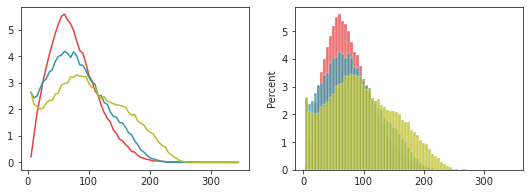

In [7]:
fig, axes = create_figure(1, 2, (9, 3))
for mode, o in bt_dict.items():
    axes[0].plot(xs, avg(cut[mode], 1), color=pal[mode])
    sns.histplot(
        data=o.run_deg[np.isfinite(o.run_deg)],
        bins=bins,
        stat='percent',
        color=pal[mode],
        ax=axes[1],
    )

In [8]:
deg_avg = {
    mode: avg(o.run_deg, 1) for
    mode, o in bt_dict.items()
}
{k: (np.round(np.nanmin(v)), np.round(np.nanmax(v))) for k, v in deg_avg.items()}

{
    'BOLD': (29.0, 125.0),
    'Ca$^{2\\!\\!+}_{slow}$': (17.0, 159.0),
    'Ca$^{2\\!\\!+}_{fast}$': (1.0, 198.0)
}

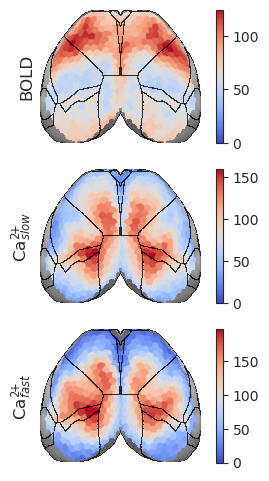

In [9]:
_ = bt.show(
    data=deg_avg,
    figsize=(4, 6),
    vmin=0,
    vmax=None,
    add_disjoint=False,
    contour_cmap='Greys_r',
    cmap='coolwarm',
    cbar=True,
)

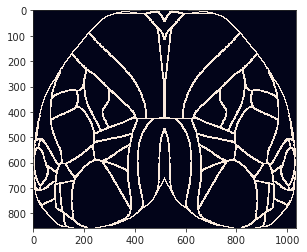

In [10]:
contour = bt.get_contour(0.2, False)
plt.imshow(contour);

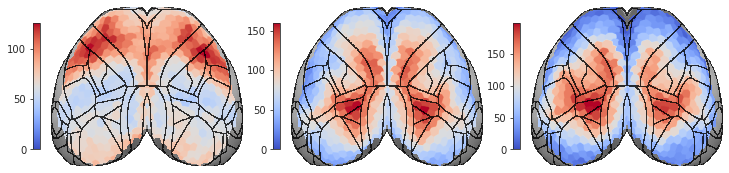

In [11]:
fig, axes = create_figure(1, 3, (10, 3), tight_layout=False, constrained_layout=True)
for ax, (mode, x) in zip(axes.flat, deg_avg.items()):
    x[x == 0] = np.nan
    
    if mode == BOLD:
        vmin = 0
        nbins = 4
    elif mode == CAS:
        vmin = 0
        nbins = 6
    elif mode == CAF:
        vmin = 0
        nbins = 6
    else:
        raise NotImplementedError
    vmax = np.nanmax(x)
    
    ax, cbar = ctx2ax(
        x=x,
        ax=ax,
        base=bt,
        vmin=vmin,
        vmax=vmax,
        cmap='coolwarm',
        cbar_shrink=0.6,
        contour=contour,
        contour_cmap='Greys_r',
        cbar_tick_nbins=nbins,
        cbar_aspect=20,
    )
remove_ticks(axes)

# fig.savefig(pjoin(fig_dir, 'ctx.png'), **kws_fig)

plt.show()

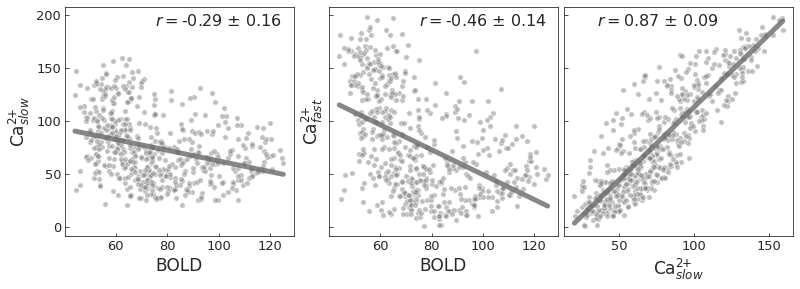

In [12]:
fig, _ = pairwise_lite(
    attr='deg',
    bt_dict=bt_dict,
    good_all=git_good('deg', bt_dict),
    n_resamples=int(1e3),
)
# fig.savefig(pjoin(fig_dir, 'pw.pdf'), **kws_fig)
# fig.savefig(pjoin(fig_dir, 'pw.png'), **kws_fig)

## Main analysis

### Get Adjs

In [13]:
adj = {}

mice.set_band()
kwargs = {
    'task': 'rest',
    'desc': {'bold': 'bp(0.01,0.5)'},
}
adj[BOLD] = collect_adjacencies(mice, 'bold-lite', **kwargs)[0]

b = (0.01, 0.5)
mice.set_band(band_ca=b)
kwargs = {
    'task': 'rest',
    'desc': {'ca2': f'bp{b}'.replace(' ', '')},
}
adj[CAS] = collect_adjacencies(mice, 'ca2', **kwargs)[0]

b = (0.5, 5.0)
mice.set_band(band_ca=b)
kwargs = {
    'task': 'rest',
    'desc': {'ca2': f'bp{b}'.replace(' ', '')},
}
adj[CAF] = collect_adjacencies(mice, 'ca2', **kwargs)[0]

In [14]:
# Adjacencies binary
adj_bin = {
    mode: np_nans((
        mice.cfg.n_subjects,
        mice.cfg.n_sessions,
        4,
        len(o.n2l),
        len(o.n2l),
    )) for mode, o in bt_dict.items()
}
for mode, a_all in adj.items():
    for ii, a in enumerate(a_all):
        thres = calculate_threshold(a, perc / 100)
        thres = thres.pop()
        _a = a.copy()
        _a[a <= thres] = 0
        _a[a > thres] = 1
        i, j, k = list(bt_dict[mode].address.values())[ii]
        adj_bin[mode][i, j, k] = _a
        
# Degree binary
deg = {
    k: bn.nansum(v, -1) for
    k, v in adj_bin.items()
}
deg_avg = {}
for k, v in deg.items():
    x = v.copy()
    x[x == 0] = np.nan
    deg_avg[k] = avg(x, 1)

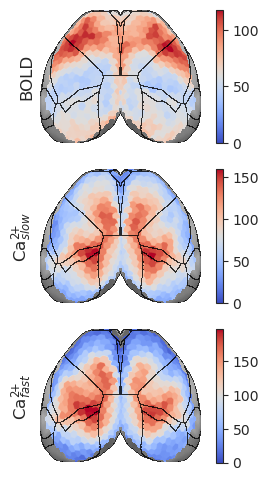

In [15]:
_ = bt.show(
    data=deg_avg,
    figsize=(4, 6),
    vmin=0,
    vmax=None,
    add_disjoint=False,
    contour_cmap='Greys_r',
    cmap='coolwarm',
    cbar=True,
)

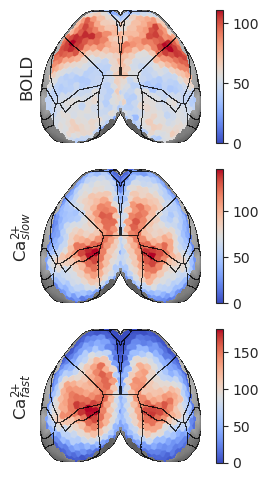

In [16]:
_ = bt.show(
    data={k: avg(v, 1) for k, v in deg.items()},
    figsize=(4, 6),
    vmin=0,
    vmax=None,
    add_disjoint=False,
    contour_cmap='Greys_r',
    cmap='coolwarm',
    cbar=True,
)

In [17]:
{k: (np.round(np.nanmin(v)), np.round(np.nanmax(v))) for k, v in deg_avg.items()}

{
    'BOLD': (26.0, 118.0),
    'Ca$^{2\\!\\!+}_{slow}$': (17.0, 159.0),
    'Ca$^{2\\!\\!+}_{fast}$': (1.0, 198.0)
}

### Get partition

In [18]:
mice.parcel.load_parcel(True)

[
    True,
    False,
    True,
    True,
    True,
    False,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    False
]

In [19]:
results = similiarity_results(
    mice=mice,
    perc=perc,
    num_k=num_k,
    merge_thres=0.444,
    n_resamples=None,
)
partition = {}
for mode, o in results['bt_dict'].items():
    partition[mode] = o.get_disjoint_community()

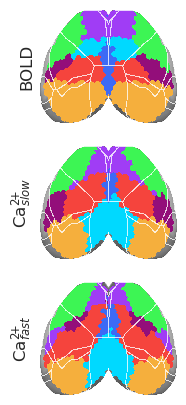

In [20]:
_ = bt.show(partition, vmin=1, vmax=7, cmap=get_cluster_cmap(range(7)), interp='none')

### Get $\kappa$

In [21]:
for mode, a in adj_bin.items():
    pt = partition[mode]
    shape = np.array(a.shape)
    shape[-2] = num_k
    kappa = np_nans(tuple(shape))
    
    for i, oc_idx in enumerate(np.unique(pt[np.isfinite(pt)])):
        nodes = pt == oc_idx
        kappa[..., i, :] = bn.nansum(a[..., nodes], -1)
    assert np.array_equal(bn.nansum(kappa, -2), deg[mode], equal_nan=True)

    x = kappa / np.nansum(kappa, -2, keepdims=True)
    x = 1 - bn.nansum(x ** 2, -2)
    bt_dict[mode].run_p = x

{k: o.run_p.shape for k, o in bt_dict.items()}

{
    'BOLD': (10, 3, 4, 542),
    'Ca$^{2\\!\\!+}_{slow}$': (10, 3, 4, 542),
    'Ca$^{2\\!\\!+}_{fast}$': (10, 3, 4, 542)
}

In [22]:
good = np.isfinite(avg(bt_dict[CAF].run_h, 1))
for k, o in bt_dict.items():
    o.run_p[..., ~good] = np.nan
    bad = avg(deg[k], 1) < 8
    o.run_p[..., bad] = np.nan
    print(k, bad.sum())

BOLD 0

Ca$^{2\!\!+}_{slow}$ 11

Ca$^{2\!\!+}_{fast}$ 82

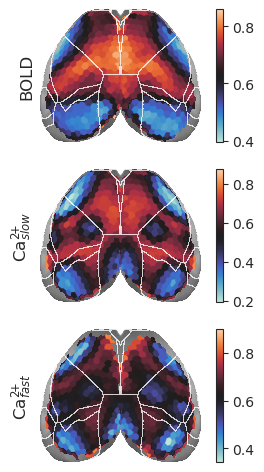

In [23]:
_ = bt.show(
    data={k: avg(o.run_p, 1) for k, o in bt_dict.items()},
    figsize=(4, 6),
    vmin=None,
    vmax=None,
    cmap='icefire',
    cbar=True,
)

In [24]:
p_avg = {k: avg(o.run_p, 1) for k, o in bt_dict.items()}

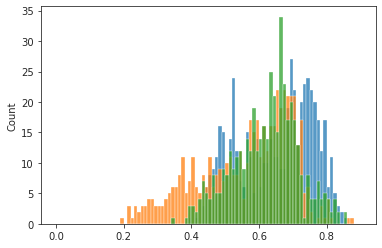

In [25]:
sns.histplot(p_avg[BOLD], color='C0', bins=np.linspace(0, 0.9, 91))
sns.histplot(p_avg[CAS], color='C1', bins=np.linspace(0, 0.9, 91))
sns.histplot(p_avg[CAF], color='C2', bins=np.linspace(0, 0.9, 91));

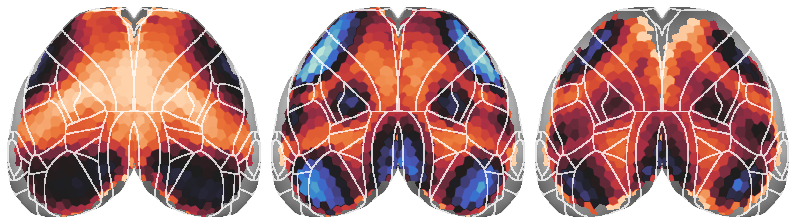

In [26]:
fig, axes = create_figure(1, 3, (11, 3), tight_layout=False, constrained_layout=True)
for ax, (mode, x) in zip(axes.flat, p_avg.items()):
    x[x == 0] = np.nan

    vmin = 0.2
    vmax = 0.8
    nbins = 5

    ax, cbar = ctx2ax(
        x=x,
        ax=ax,
        base=bt,
        vmin=vmin,
        vmax=vmax,
        cmap='icefire',
        # cbar_shrink=0.6,
        contour=contour,
        contour_cmap='Greys',
        # cbar_tick_nbins=nbins,
        # cbar_aspect=20,
        cbar=False,
    )
remove_ticks(axes)

fig.savefig(pjoin(fig_dir, 'particip_ctx_nocbar.png'), **kws_fig)

plt.show()

## Continued from here bvefore -----

In [27]:
mode = BOLD
good = np.isfinite(p_avg[mode])
sp_stats.pearsonr(p_avg[mode][good], avg(bt_dict[mode].run_h, 1)[good])

(0.7135117375656588, 1.2841740081587007e-83)

In [28]:
mode = CAS
good = np.isfinite(p_avg[mode])
sp_stats.pearsonr(p_avg[mode][good], avg(bt_dict[mode].run_h, 1)[good])

(0.7695789332481637, 3.784281955896754e-104)

In [29]:
mode = CAF
good = np.isfinite(p_avg[mode])
sp_stats.pearsonr(p_avg[mode][good], avg(bt_dict[mode].run_h, 1)[good])

(0.47342097211823797, 4.516649370030894e-27)

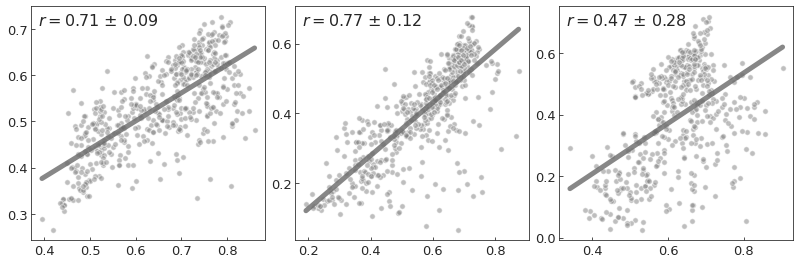

In [31]:
fig, _ = pairwise_lite_2('p', 'h', bt_dict, add_labels=False)
fig.savefig(pjoin(fig_dir, 'p_vs_h.png'), **kws_fig)

In [30]:
def pairwise_lite_2(
        attr_1: str,
        attr_2: str,
        bt_dict: dict,
        good_all: np.ndarray = None,
        n_resamples: int = int(1e2),
        add_labels: bool = True,
        display: bool = True,
        **kwargs, ):
    defaults = {
        'figsize': (11, 4),
        'tval': get_tval(9, 0.95),
        'palette': prepare_palette(),
        'ylim_lower': -0.03,
        'line_lw': 5,
        'line_alpha': 0.8,
        'scatter_s': 30,
        'scatter_alpha': 0.5,
        'line_color': 'dimgrey',
        'scatter_color': 'C7',
        'scatter_edgecolor': 'w',
        'annot_xy': {
            0: (0.03, 0.92),
            1: (0.03, 0.92),
            2: (0.03, 0.92)},
        'annot_fontsize': 16,
        'label_fontsize': 17,
        'legend_fontsize': 14,
        'legend_loc': 'best',
        'tick_direction': 'in',
        'tick_labelsize': 13,
        'tick_nbins': 6,
    }
    for k, v in defaults.items():
        if k not in kwargs:
            kwargs[k] = v
    assert attr_1 in ['deg', 'h', 'hr', 'p'], f"wrong attribute: '{attr_1}'"
    assert attr_2 in ['deg', 'h', 'hr', 'p'], f"wrong attribute: '{attr_2}'"
    attr_1 = f"run_{attr_1}"
    attr_2 = f"run_{attr_2}"

    fig, axes = create_figure(
        nrows=1,
        ncols=3,
        figsize=kwargs['figsize'],
        constrained_layout=True,
        tight_layout=False,
    )
    for idx, (mode, o) in enumerate(bt_dict.items()):
        x_1 = avg(getattr(o, attr_1), 1)
        x_2 = avg(getattr(o, attr_2), 1)
        if good_all is None:
            good = np.logical_and(
                np.isfinite(x_1),
                np.isfinite(x_2),
            )
        else:
            good = good_all
        # scatter
        ax = axes.flat[idx]
        ax.scatter(
            x=x_1[good],
            y=x_2[good],
            s=kwargs['scatter_s'],
            alpha=kwargs['scatter_alpha'],
            color=kwargs['scatter_color'],
            edgecolor=kwargs['scatter_edgecolor'],
        )
        # linear regression
        lr = sp_stats.linregress(
            x=x_1[good],
            y=x_2[good],
        )

        x_min = x_1[good].min()
        x_max = x_1[good].max()
        xs = np.linspace(x_min, x_max, 1000)
        ys = lr.slope * xs + lr.intercept
        if kwargs['ylim_lower']:
            ys[ys < kwargs['ylim_lower'] * 0.7] = np.nan
        ax.plot(
            xs, ys,
            lw=kwargs['line_lw'],
            alpha=kwargs['line_alpha'],
            color=kwargs['line_color'],
        )
        if add_labels:
            ax.set_xlabel(
                xlabel=lbl_1,
                fontsize=kwargs['label_fontsize'],
            )
            if idx < 2:
                ax.set_ylabel(
                    ylabel=lbl_2,
                    fontsize=kwargs['label_fontsize'],
                )

        rho, se = corr_group(
            x=getattr(o, attr_1)[..., good],
            y=getattr(o, attr_2)[..., good],
            n_resamples=n_resamples,
        )
        text = r"$r = $" + f"{rho[0]:0.2f} " + r"$\pm$"
        text += f" {se * kwargs['tval']:0.2f}"
        ax.annotate(
            text=text,
            xy=kwargs['annot_xy'][idx],
            xycoords='axes fraction',
            fontsize=kwargs['annot_fontsize'],
        )
        ax.locator_params(
            axis='both',
            nbins=kwargs['tick_nbins'],
        )
        set_tickparams(ax, **kwargs)
    if kwargs['ylim_lower']:
        ylim = axes[-1].get_ylim()
        ylim = np.maximum(kwargs['ylim_lower'], ylim)
        axes[-1].set_ylim(ylim)
    _ = ax_square(axes)

    if display:
        plt.show()
    else:
        plt.close()
    return fig, axes